# Modulacion

In [97]:
import matplotlib.pyplot as plt
import numpy as np
def generate_time_samples(spreading_factor, bandwidth, samples_per_chip):
    
    # Definimos la duración de símbolo en segundos
    symbol_time = ( 2**spreading_factor ) / bandwidth

    # Definimos la cantidad de muestras por símbolo
    samples_per_symbol = int( ( 2**spreading_factor ) * samples_per_chip )

    # Generamos las muestras de tiempo (serán 129 muestras equiespaciadas, para luego sacar la última, asi logramos el punto 1 y punto 2 en una sola línea de código)
    # También es equivalente si establecemos el parámetro de numpy.linspace "endpoint" a False, pero de esta forma se entiende mejor el concepto.
    # La función numpy.linspace genera un vector de muestras equiespaciadas. Esto es mejor que utilizar np.arange, ya que acumula más errores de redondeo. (ver: https://numpy.org/doc/stable/reference/generated/numpy.arange.html)
    timeline = np.linspace(0, symbol_time, samples_per_symbol + 1)
    timeline = timeline[0:-1]

    return timeline


In [98]:
def generate_frequency_evolution(timeline, symbol, spreading_factor, bandwidth):
    frequency_slope = bandwidth**2 / ( 2**spreading_factor )
    y_intercept = symbol * (bandwidth/2**spreading_factor)
    frequency_evolution = ( y_intercept + frequency_slope * timeline ) % bandwidth
    return frequency_evolution

In [99]:
def generate_signal_phase(timeline, symbol, spreading_factor, bandwidth):
    auxiliar_slope = (bandwidth**2/2**(spreading_factor + 1))
    auxiliar_intercept = symbol * (bandwidth/2**spreading_factor)
    discontinuity_time = (2**spreading_factor - symbol) * (1/bandwidth)

    signal_phase = [
        (auxiliar_intercept + auxiliar_slope * t) * t - (t - discontinuity_time) * bandwidth 
        if t >= discontinuity_time 
        else (auxiliar_intercept + auxiliar_slope * t) * t
        for t in timeline
    ]    
    signal_phase = [inst_phase * (2*np.pi) for inst_phase in signal_phase ]
    return signal_phase

In [100]:
def generate_signal(timeline, symbol, spreading_factor, bandwidth, samples_per_chip):
    signal = np.array([])
    # signal = coeff*e^(j* phase)
    signal_coefficient = 1/np.sqrt(2**spreading_factor * samples_per_chip)
    signal_phase = generate_signal_phase(timeline, symbol, spreading_factor, bandwidth)
    signal = [signal_coefficient * (np.cos(instantaneous_phase) + 1j*np.sin(instantaneous_phase)) for instantaneous_phase in signal_phase]
    signal = [signal_coefficient * np.exp(1j * instantaneous_phase) for instantaneous_phase in signal_phase]
    
    return signal

# Demodulación

In [101]:
def generate_downchirp(sf, bw, timeline, also_return_freq=False, samples_per_chip = 1):
    '''
    This function generates a downchirp signal for a given spreading factor, bandwidth, timeline and samples per chip.
    Parameters:
    sf: spreading factor
    bw: bandwidth
    timeline: discrete timeline
    also_return_freq: boolean to also return the frequency evolution of the downchirp across the timeline
    samples_per_chip: samples per chip
    '''
    # sf: spreading factor
    # freq: frequency
    # timeline: timeline
    y_intercept = 0
    theoretical_symbol_time = (2**sf) / bw
    freqs = []
    slope = - bw / theoretical_symbol_time
    coeff = 1/(np.sqrt(2**sf * samples_per_chip) )
    signal = []

    for i in range(len(timeline)):
        freq = y_intercept + slope * timeline[i]
        integrated_freq = y_intercept + 0.5 * slope * timeline[i] * timeline[i]
        inst_phase = 2 * np.pi * (integrated_freq) 
        signal.append( coeff * np.exp(1j * inst_phase))
        freqs.append(freq)
        

    if also_return_freq:
        return signal, freqs
    # conjugate because we are generating a downchirp
    # signal = np.conj(signal)
    return signal


def multiply(signal, sf, downchirp):

    product = []
    for i in range(len(signal)):
        product.append(signal[i] * downchirp[i])

    return product

Simbolo estimado  40
simbolo enviado  40


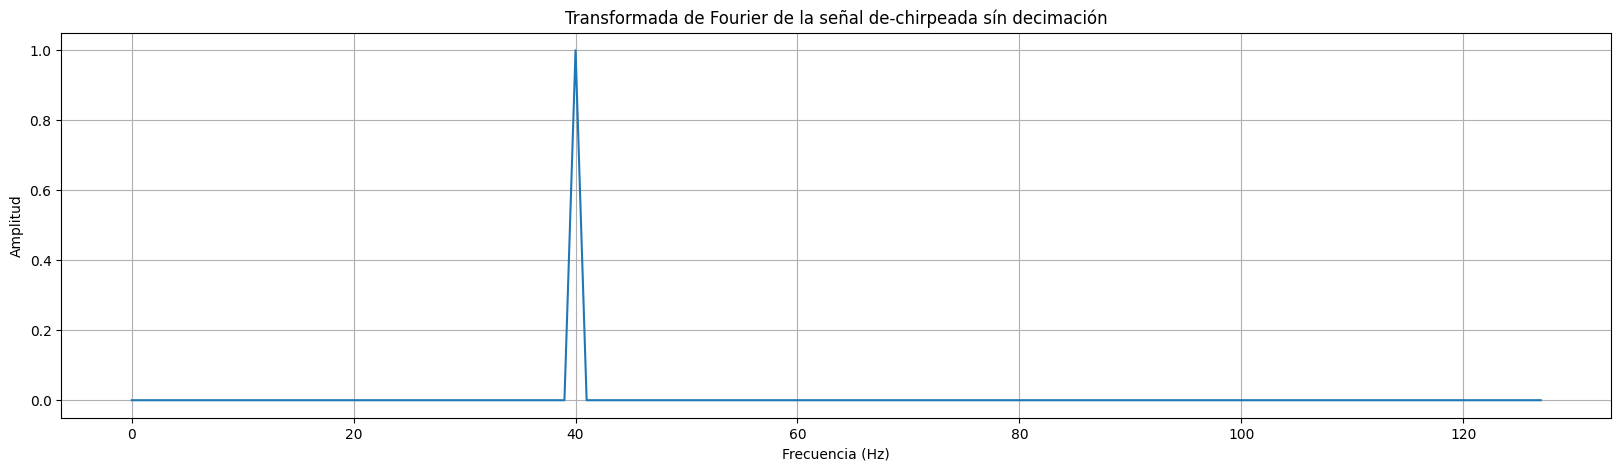

In [102]:
def correlate(signal, sf, downchirp, return_symbol_instead=False):
    '''
    This function correlates a signal with a downchirp signal, resulting in the demodulation of the message.
    Parameters:
    signal: complex signal (array)
    sf: spreading factor
    downchirp: downchirp signal (array)
    return_symbol_instead: boolean to return the symbol instead of the fourier transform
    '''
    product = []
    for i in range(len(signal)):
        product.append(signal[i] * downchirp[i])

    fourier_transform = np.fft.fft(product)
    
    if return_symbol_instead:
        return np.argmax(np.abs(fourier_transform))  
    return fourier_transform

spreading_factor, bandwidth, samples_per_chip = 7, 125e3, 1 #  Definimos los parámetros
symbol = np.random.randint(0,2**spreading_factor) # Definimos el símbolo a analizar
timeline = generate_time_samples(spreading_factor, bandwidth, samples_per_chip) # Generamos las muestras de tiempo
signal = generate_signal(timeline, symbol, spreading_factor, bandwidth, samples_per_chip) # Generamos la señal
downchirp = generate_downchirp(spreading_factor, bandwidth, timeline) # Generamos el downchirp

fourier_transform = correlate(signal, spreading_factor, downchirp) # Correlacionamos la señal con el downchirp

# Combinamos linealmente la transformada de fourier cada 2**spreading_factor muestras


plt.figure(figsize=(20, 5))
plt.plot(fourier_transform)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Transformada de Fourier de la señal de-chirpeada sín decimación')
plt.grid(True)
if samples_per_chip > 1:
    fft_ideal_length = 2**spreading_factor
    custom_decimated_fourier_transform = [fourier_transform[i]+ fourier_transform[i + (samples_per_chip-1)*2**spreading_factor] for i in range(fft_ideal_length)]

    plt.figure(figsize=(20, 5))
    plt.plot(custom_decimated_fourier_transform)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.title('Transformada de Fourier de la señal de-chirpeada con decimación')
    plt.grid(True)
    print("Simbolo estimado ", np.argmax(custom_decimated_fourier_transform))

    print("simbolo enviado ", symbol)
else:
    print("Simbolo estimado ", np.argmax(np.abs(fourier_transform)))
    print("simbolo enviado ", symbol)
plt.show()